In [1]:
import sys
sys.executable

'/Users/brianmcmahon/anaconda3/envs/recommender/bin/python'

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from os import path, getcwd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image

from gensim import matutils, models

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [3]:
tag_data = pd.read_csv('../data/recsys_tags2.csv')
tag_data = tag_data.set_index(['idx'])
tag_data['tags'] = tag_data['tags'].apply(lambda x: ', '.join(x.split('|')))
tag_data.head()

,name,tags
idx,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter..."
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt..."
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv..."
3,50 Cent,"00s, american, awesome, catchy, club, dance, g..."
4,A Day to Remember,"<3, acoustic, alternative, american, christian..."


In [4]:
tag_data.tags[0]

'00s, 2008, 90s, acoustic, acoustic rock, alternative, alternative rock, american, awesome, cute, grunge, guilty pleasure, hard rock, love, male vocalists, melancholic, other great tracks, pop, pop rock, post-grunge, prejebeno, punk, rock, romantic, soft rock, soundtrack'

### K Means Clustering + tSNE

In [5]:
data = tag_data.tags
seed = 42
n_clusters = 6

In [18]:
def generate_wordcloud(text):  
    # TODO find better mask, seem to be size issues
    mask=np.array(Image.open('../data/play.png'))
    stopwords = set(STOPWORDS)
    add_stopwords = ['rock','pop','hardcore']
    for word in add_stopwords:
        stopwords.add(word)
    wc = WordCloud(background_color='black',
                          max_words=2000,
                          mask=mask,
                          colormap='magma',
                          stopwords=stopwords).generate(text)
    
#     image_colors = ImageColorGenerator(mask)
#     plt.figure(figsize=[7,7])
    plt.imshow(wc, 
               interpolation="bilinear") #.recolor(color_func=image_colors)
    plt.axis("off")
    title = "Topic {}".format(i)
    plt.title(title,fontweight='bold',fontsize=16)   
#     _=plt.show()

In [19]:
tfidf = TfidfVectorizer(max_df=0.6)
X = tfidf.fit_transform(data)
nmf = NMF(n_components=n_clusters, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
X_reduced = nmf.fit_transform(X)

KMC saved at ../charts/kmc_.png
Inertia score: 3.2557713013456424
Silhouette score: 0.4640277002561153
Cluster 0 has 137 comments.
Cluster 1 has 60 comments.
Cluster 2 has 60 comments.
Cluster 3 has 38 comments.
Cluster 4 has 131 comments.
Cluster 5 has 79 comments.


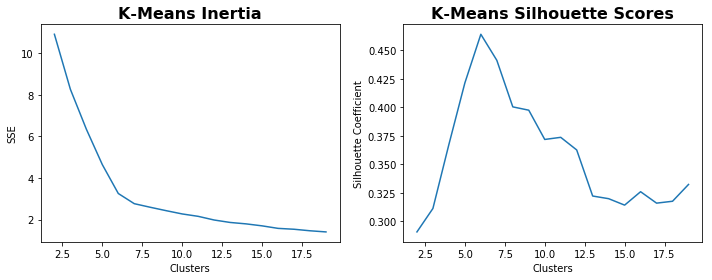

In [20]:
# plot K Means Clusters Silhouette and Clusters Analysis
ns = np.arange(2, 20, 1)
inertias = []
silhouettes = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)
    silhouettes.append(ss)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('K-Means Inertia', fontweight='bold',fontsize=16)

ax = fig.add_subplot(1,2,2)
# plot the silhouette scores
plt.plot(ns, silhouettes)
plt.xlabel('Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('K-Means Silhouette Scores', fontweight='bold',fontsize=16)

plt.tight_layout()
filepath1 = "../charts/kmc_.png"
plt.savefig(filepath1)
print("KMC saved at " + filepath1)
# Fit Kmeans with n_clusters
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=seed)
kmf = kmeans.fit(X_reduced)
labels = kmf.labels_
ssc = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)

print("Inertia score: {}".format(kmf.inertia_))
print("Silhouette score: {}".format(ssc))
for cluster in range(len(set(labels))):
    print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster)))

WordClouds saved at ../charts/wc_kmctsne.png


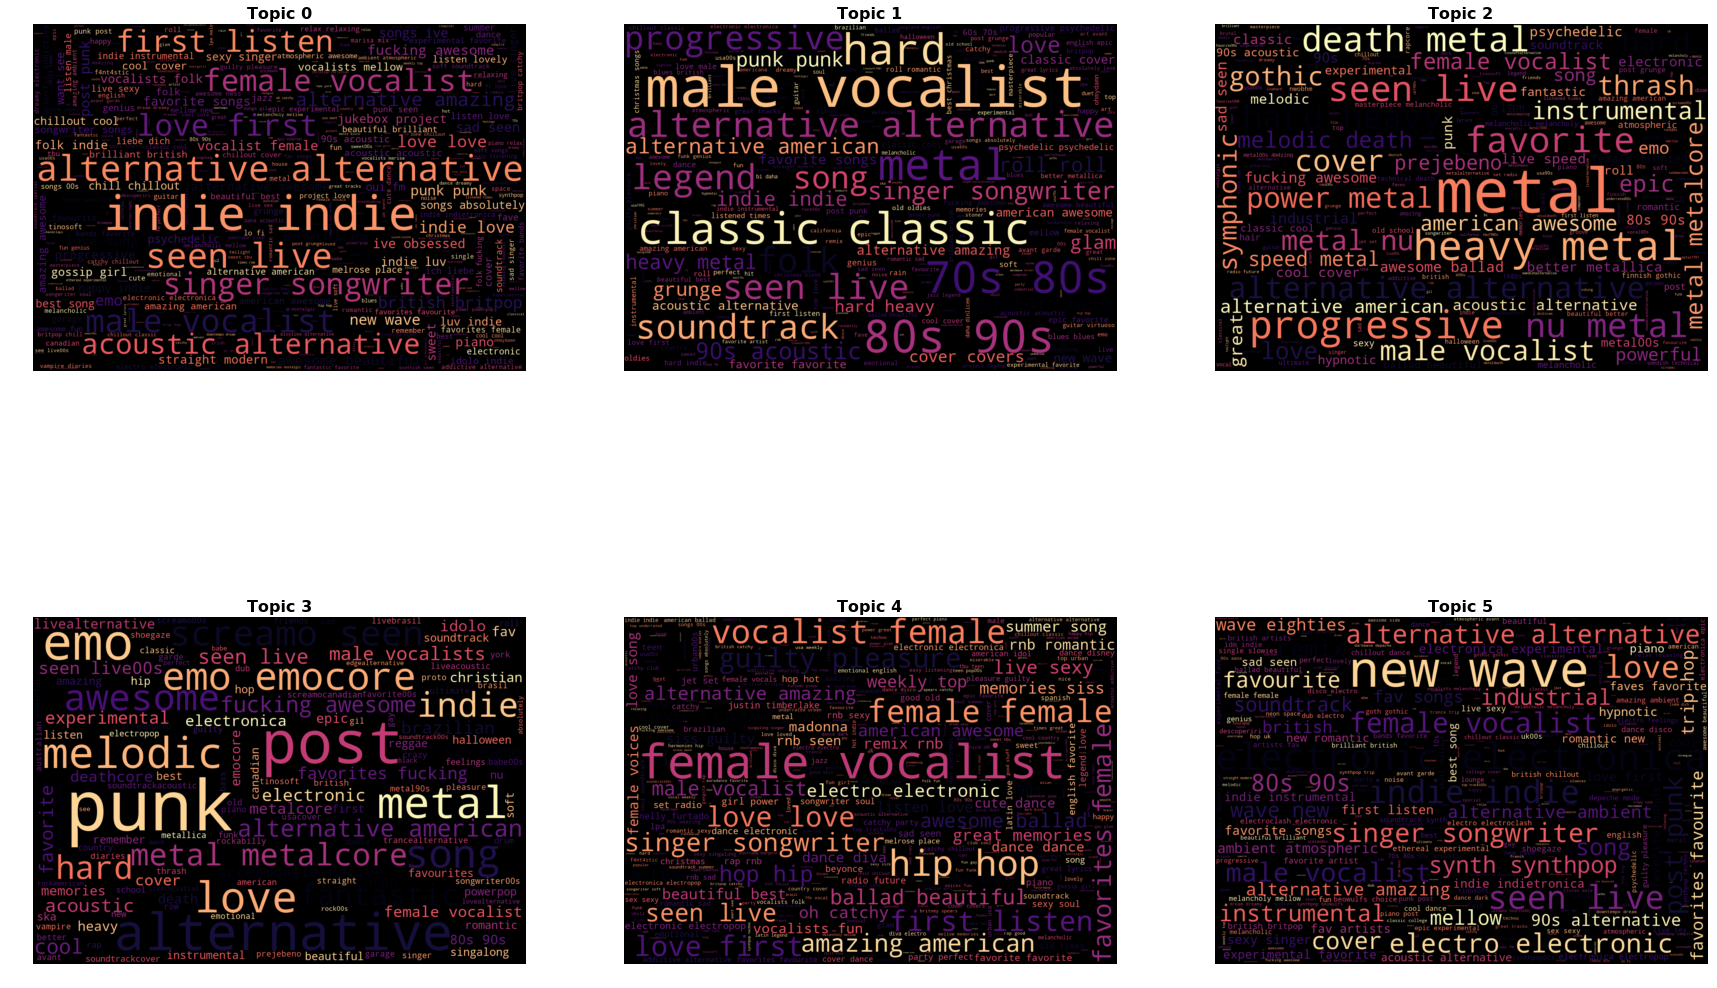

In [21]:
cluster_map = pd.DataFrame(X_reduced)
cluster_map['comments'] = [r for r in data]
cluster_map['cluster'] = labels

fig = plt.figure(figsize=(30,20))
ncols = 3
nrows = math.ceil(n_clusters / ncols)
plt.tight_layout()

for i in range(n_clusters):
    ax = fig.add_subplot(nrows,ncols,i+1)
    text = ''.join(cluster_map[cluster_map.cluster==i].comments)
    
    generate_wordcloud(text)

#     wordcloud = WordCloud(stopwords=STOPWORDS).generate(text) #, width=400,height=200,max_words=50
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     title = "Cluster {}".format(i)
#     plt.title(title,fontweight='bold',fontsize=16)    
    
filepath3 = "../charts/wc_kmctsne.png"
print("WordClouds saved at " + filepath3)
plt.savefig(filepath3)

T-SNE saved at ../charts/tsne.png


<Figure size 4320x4320 with 0 Axes>

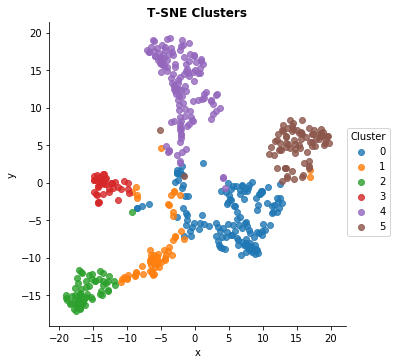

In [22]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=seed)
tsne = tsne.fit_transform(X_reduced)
df_tsne = pd.DataFrame(tsne, columns=["tsne_x", "tsne_y"])
df_tsne["Cluster"] = labels

fig = plt.figure(figsize=(60,60))
tsne = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("T-SNE Clusters",fontweight='bold')
filepath2 = "../charts/tsne.png"
plt.savefig(filepath2)
print("T-SNE saved at " + filepath2)

### LDA

In [23]:
data = tag_data.tags
num_topics = 6
ngram_range = (1,2)
max_words = 10

# seed = 42
# n_clusters = 6

Chart saved at ../charts/5.png


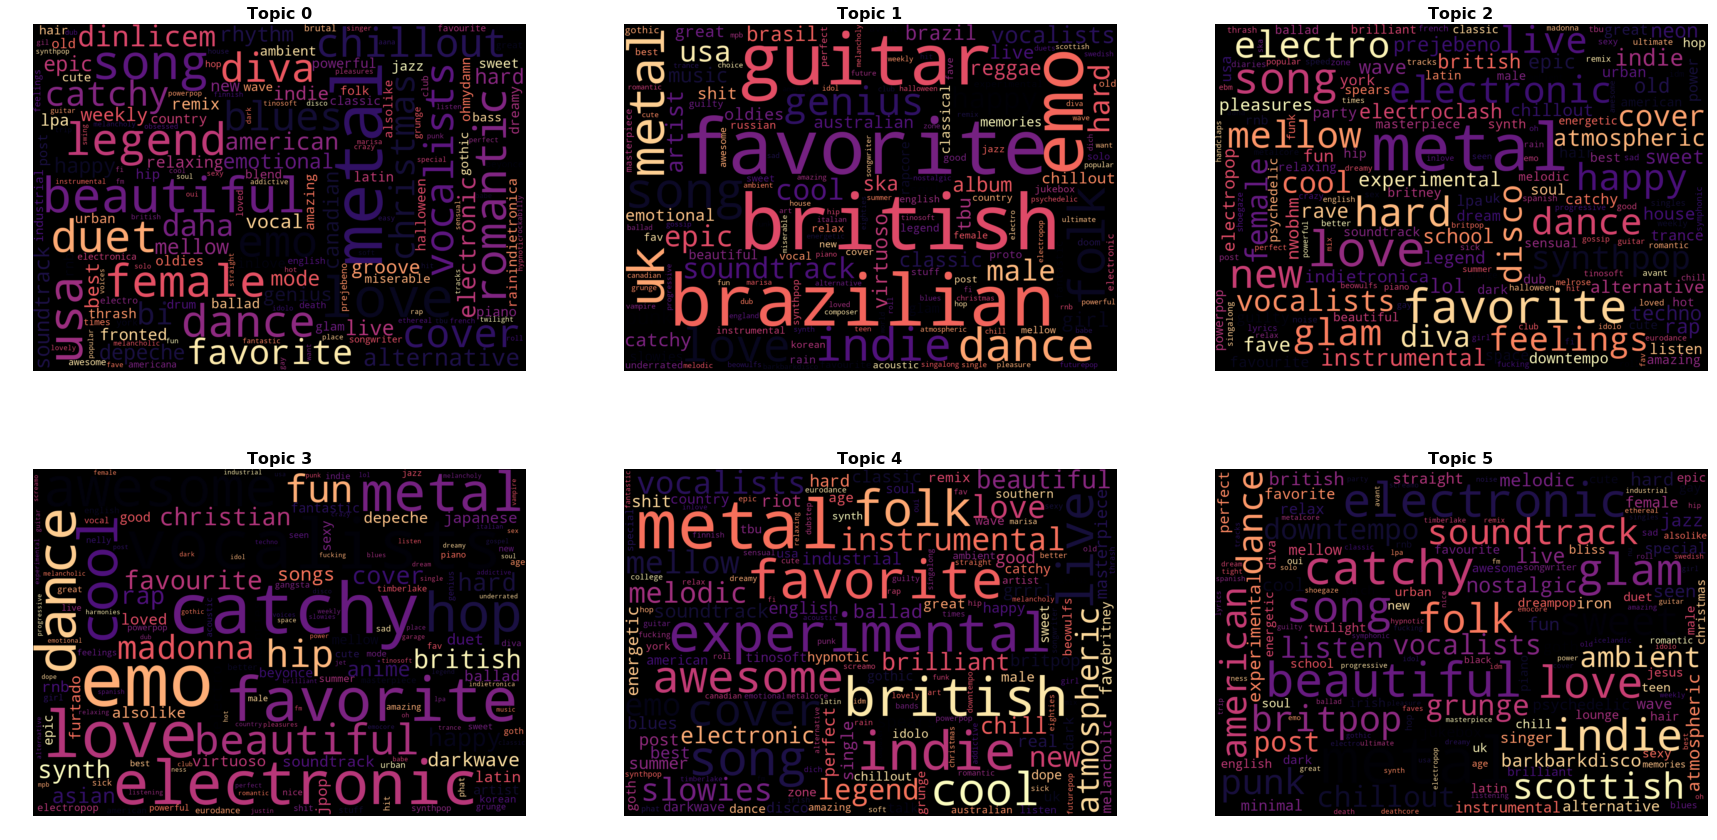

In [24]:
fig = plt.figure(figsize=(30,15))
topics_dict = {}
count_vectorizer = CountVectorizer(ngram_range=ngram_range,  stop_words='english', max_df=0.02, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(data)
counts = count_vectorizer.transform(data).transpose()
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10) # minimum_probability=0.03, 
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
topics = lda.print_topics(num_words=200)
i = 0
for topic in topics:
#     print(topic)
    topics_dict[topic[0]] = lda_docs # , lda.log_perplexity
    nrows = math.ceil(num_topics / 3)
    ax = fig.add_subplot(nrows,3,i+1)
    topics_dict[topic[0]] = topic
    title = " Topic: " + str(topic[0])
    filepath = '../charts/' + str(topic[0]) + '.png'
    
    generate_wordcloud(topic[1])

#     wordcloud = WordCloud(stopwords=STOPWORDS).generate(topic[1]) #width=width,height=height,max_words=max_words
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(title,fontweight='bold',fontsize=16)       

    i+=1
plt.savefig(filepath)
print("Chart saved at {}".format(filepath))

### TF-IDF / NMF

In [25]:
data = tag_data.tags
model_list = ['LDA','NMF-FN','NMF-KL']
class_list = ['all']
ngram_range = (2,3)
max_iter = 100000
max_df = .01
min_df = 1
n_components = 6 
n_features = 1000
n_top_words = 20
ncols = 6

In [26]:
def print_top_words(model, feature_names, n_top_words):
    listy = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        listy.append(message)
    return listy  

saved at ../charts/tfidfnmflda_wcallNMF-FN
saved at ../charts/tfidfnmflda_wcallNMF-KL
saved at ../charts/tfidfnmflda_wcallLDA


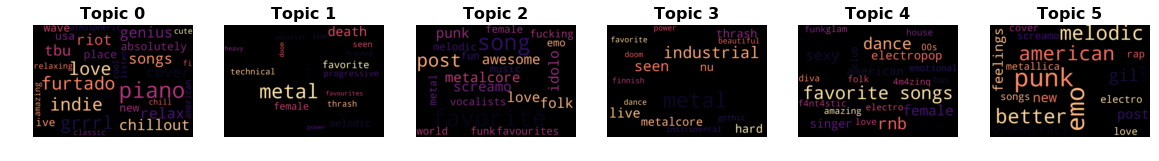

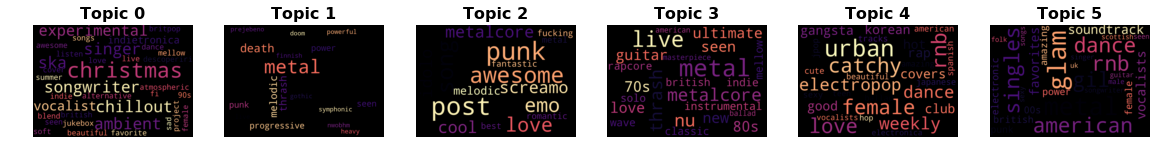

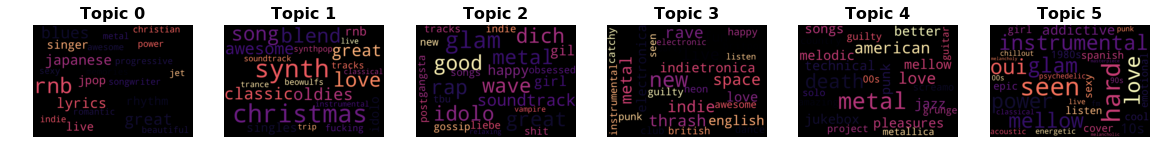

In [27]:
class_tfidfnmf = {}
for item in class_list:
#     if item == 'all':
#         data = tag_data.tags
#     else:
#         data = dataset[dataset[item]==1]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range,
                                       max_df=max_df, 
                                       min_df=min_df,
                                       max_features=n_features,
                                       stop_words='english')
    
    tfidf = tfidf_vectorizer.fit_transform(data)

    tf_vectorizer = CountVectorizer(ngram_range=ngram_range,
                                    max_df=max_df, 
                                    min_df=min_df,
                                    max_features=n_features,
                                    stop_words='english')
    
    tf = tf_vectorizer.fit_transform(data)

    nmf = NMF(n_components=n_components, 
              random_state=seed,
              alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    aa = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    nmf = NMF(n_components=n_components, 
              random_state=seed,
              beta_loss='kullback-leibler', 
              solver='mu', 
              max_iter=max_iter, 
              alpha=.1,
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    bb = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=seed)
    lda.fit(tf)

    tf_feature_names = tf_vectorizer.get_feature_names()

    cc = print_top_words(lda, 
                         tf_feature_names, 
                         n_top_words)
    
    class_tfidfnmf[item] = {'NMF-FN':aa, 'NMF-KL':bb, 'LDA':cc}
    
    # plot wordclouds
    for e in class_tfidfnmf[item]:
        fig = plt.figure(figsize=(20,20))
        chart_tot = n_components * len(class_list) * len(model_list)
        ncols = ncols
        nrows = math.ceil(chart_tot / ncols)
        for i in range(n_components):
            ax = fig.add_subplot(nrows,ncols,i+1)
            text = ' '.join(class_tfidfnmf[item][e][i].split()[2:])
            title = "Topic: " + str(item) + "_" + str(e) + "_" + "_" + str(i)
            
            generate_wordcloud(text)
            
#             wordcloud = WordCloud(stopwords=STOPWORDS).generate(text)
#             plt.imshow(wordcloud, interpolation="bilinear")
#             plt.axis("off")
#             plt.title(title,fontweight='bold',fontsize=16)            
            
#             create_wordcloud(data,400,200,200,title)
#             fig.tight_layout()
        filepath = '../charts/tfidfnmflda_wc' + str(item) + str(e)
        plt.savefig(filepath)
        print('saved at ' + filepath)

### pyLDAvis

In [33]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(data)
print(dtm_tf.shape)

(505, 264)


In [36]:
lda_tf = LatentDirichletAllocation(n_topics=6, random_state=seed)
lda_tf.fit(dtm_tf)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=6,
             perp_tol=0.1, random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [37]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.086359  0.109418       1        1  28.551106
3      0.073570  0.058659       2        1  22.748678
2     -0.183610  0.094236       3        1  14.101707
1     -0.029228 -0.094247       4        1  12.987614
0      0.263534  0.044157       5        1  12.927516
5     -0.037907 -0.212223       6        1   8.683379, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
160   Default  391.000000         metal  391.000000  30.0000  30.0000
85    Default  415.000000        female  415.000000  29.0000  29.0000
128   Default  462.000000         indie  462.000000  28.0000  28.0000
168   Default  157.000000           new  157.000000  27.0000  27.0000
120   Default  140.000000           hop  140.000000  26.0000  26.0000
192   Default  247.000000          punk  247.000000  25.0000  25.0000
260   Default  117.000000          wave  117.000000  24.0000  24.0000
118   Default  106.000000           hip  106.000000  23.0000  23.0000
114   Default  122.000000          hard  122.000000  22.0000  22.0000
46    Default  206.000000         dance  206.000000  21.0000  21.0000
117   Default   59.000000         heavy   59.000000  20.0000  20.0000
64    Default  188.000000    electronic  188.000000  19.0000  19.0000
189   Default   98.000000   progressive   98.000000  18.0000  18.0000
6     Default   72.000000       ambient   72.000000  17.0000  17.0000
115   Default   99.000000      hardcore   99.000000  16.0000  16.0000
75    Default  105.000000  experimental  105.000000  15.0000  15.0000
239   Default   61.000000      synthpop   61.000000  14.0000  14.0000
184   Default  144.000000          post  144.000000  13.0000  13.0000
30    Default  122.000000        catchy  122.000000  12.0000  12.0000
26    Default  134.000000       british  134.000000  11.0000  11.0000
62    Default   99.000000       electro   99.000000  10.0000  10.0000
238   Default   38.000000         synth   38.000000   9.0000   9.0000
65    Default   89.000000   electronica   89.000000   8.0000   8.0000
199   Default   61.000000         remix   61.000000   7.0000   7.0000
132   Default   95.000000  instrumental   95.000000   6.0000   6.0000
48    Default   40.000000         death   40.000000   5.0000   5.0000
200   Default   77.000000           rnb   77.000000   4.0000   4.0000
201   Default   67.000000          roll   67.000000   3.0000   3.0000
67    Default   90.000000           emo   90.000000   2.0000   2.0000
191   Default   72.000000   psychedelic   72.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
168    Topic6   93.322036           new  157.165978   1.9225  -2.6149
248    Topic6    9.892347        trance   17.011961   1.9016  -4.8592
241    Topic6   14.189438        techno   24.451901   1.8995  -4.4985
39     Topic6    7.956619       college   14.119104   1.8702  -5.0770
79     Topic6   11.755116         faves   21.617254   1.8346  -4.6867
52     Topic6   15.825040         disco   31.049825   1.7698  -4.3894
16     Topic6   12.888570         bands   25.512740   1.7609  -4.5946
71     Topic6    6.275901       england   12.441801   1.7594  -5.3142
199    Topic6   26.749124         remix   61.809319   1.6062  -3.8645
99     Topic6    4.781279        german   11.666990   1.5517  -5.5863
130    Topic6   12.751768    industrial   31.659402   1.5344  -4.6053
105    Topic6   15.601042        gothic   42.296254   1.4464  -4.4036
26     Topic6   44.896617       british  134.957721   1.3432  -3.3466
194    Topic6    6.428004          rain   19.684649   1.3246  -5.2903
228    Topic6    6.067846         space   21.275026   1.1892  -5.3480
65     Topic6   24.986398   electronica   89.769048   1.1649  -3.9326
62     Topic6   25.954226       electro   99.727184   1.0977  -3.8946
122    Topic6    9.991325

In [ ]:
# 1. teen pop
# 2. punk
# 3. hip hop
# 4. electronic
# 5. heavy metal
# 6. electronic

In [38]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.101402  0.084966       1        1  28.551106
3      0.177083  0.009279       2        1  22.748678
2     -0.203444  0.040954       3        1  14.101707
1      0.089247 -0.161307       4        1  12.987614
0      0.149517  0.248672       5        1  12.927516
5     -0.111002 -0.222563       6        1   8.683379, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
160   Default  391.000000         metal  391.000000  30.0000  30.0000
85    Default  415.000000        female  415.000000  29.0000  29.0000
128   Default  462.000000         indie  462.000000  28.0000  28.0000
168   Default  157.000000           new  157.000000  27.0000  27.0000
120   Default  140.000000           hop  140.000000  26.0000  26.0000
192   Default  247.000000          punk  247.000000  25.0000  25.0000
260   Default  117.000000          wave  117.000000  24.0000  24.0000
118   Default  106.000000           hip  106.000000  23.0000  23.0000
114   Default  122.000000          hard  122.000000  22.0000  22.0000
46    Default  206.000000         dance  206.000000  21.0000  21.0000
117   Default   59.000000         heavy   59.000000  20.0000  20.0000
64    Default  188.000000    electronic  188.000000  19.0000  19.0000
189   Default   98.000000   progressive   98.000000  18.0000  18.0000
6     Default   72.000000       ambient   72.000000  17.0000  17.0000
115   Default   99.000000      hardcore   99.000000  16.0000  16.0000
75    Default  105.000000  experimental  105.000000  15.0000  15.0000
239   Default   61.000000      synthpop   61.000000  14.0000  14.0000
184   Default  144.000000          post  144.000000  13.0000  13.0000
30    Default  122.000000        catchy  122.000000  12.0000  12.0000
26    Default  134.000000       british  134.000000  11.0000  11.0000
62    Default   99.000000       electro   99.000000  10.0000  10.0000
238   Default   38.000000         synth   38.000000   9.0000   9.0000
65    Default   89.000000   electronica   89.000000   8.0000   8.0000
199   Default   61.000000         remix   61.000000   7.0000   7.0000
132   Default   95.000000  instrumental   95.000000   6.0000   6.0000
48    Default   40.000000         death   40.000000   5.0000   5.0000
200   Default   77.000000           rnb   77.000000   4.0000   4.0000
201   Default   67.000000          roll   67.000000   3.0000   3.0000
67    Default   90.000000           emo   90.000000   2.0000   2.0000
191   Default   72.000000   psychedelic   72.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
168    Topic6   93.322036           new  157.165978   1.9225  -2.6149
248    Topic6    9.892347        trance   17.011961   1.9016  -4.8592
241    Topic6   14.189438        techno   24.451901   1.8995  -4.4985
39     Topic6    7.956619       college   14.119104   1.8702  -5.0770
79     Topic6   11.755116         faves   21.617254   1.8346  -4.6867
52     Topic6   15.825040         disco   31.049825   1.7698  -4.3894
16     Topic6   12.888570         bands   25.512740   1.7609  -4.5946
71     Topic6    6.275901       england   12.441801   1.7594  -5.3142
199    Topic6   26.749124         remix   61.809319   1.6062  -3.8645
99     Topic6    4.781279        german   11.666990   1.5517  -5.5863
130    Topic6   12.751768    industrial   31.659402   1.5344  -4.6053
105    Topic6   15.601042        gothic   42.296254   1.4464  -4.4036
26     Topic6   44.896617       british  134.957721   1.3432  -3.3466
194    Topic6    6.428004          rain   19.684649   1.3246  -5.2903
228    Topic6    6.067846         space   21.275026   1.1892  -5.3480
65     Topic6   24.986398   electronica   89.769048   1.1649  -3.9326
62     Topic6   25.954226       electro   99.727184   1.0977  -3.8946
122    Topic6    9.991325

In [39]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      93.013336  41.924427       1        1  28.551106
3      -7.257101 -72.205452       2        1  22.748678
2       6.779485  79.065010       3        1  14.101707
1     -55.190956   8.528858       4        1  12.987614
0      84.338272 -51.565910       5        1  12.927516
5      24.336605   1.149389       6        1   8.683379, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
160   Default  391.000000         metal  391.000000  30.0000  30.0000
85    Default  415.000000        female  415.000000  29.0000  29.0000
128   Default  462.000000         indie  462.000000  28.0000  28.0000
168   Default  157.000000           new  157.000000  27.0000  27.0000
120   Default  140.000000           hop  140.000000  26.0000  26.0000
192   Default  247.000000          punk  247.000000  25.0000  25.0000
260   Default  117.000000          wave  117.000000  24.0000  24.0000
118   Default  106.000000           hip  106.000000  23.0000  23.0000
114   Default  122.000000          hard  122.000000  22.0000  22.0000
46    Default  206.000000         dance  206.000000  21.0000  21.0000
117   Default   59.000000         heavy   59.000000  20.0000  20.0000
64    Default  188.000000    electronic  188.000000  19.0000  19.0000
189   Default   98.000000   progressive   98.000000  18.0000  18.0000
6     Default   72.000000       ambient   72.000000  17.0000  17.0000
115   Default   99.000000      hardcore   99.000000  16.0000  16.0000
75    Default  105.000000  experimental  105.000000  15.0000  15.0000
239   Default   61.000000      synthpop   61.000000  14.0000  14.0000
184   Default  144.000000          post  144.000000  13.0000  13.0000
30    Default  122.000000        catchy  122.000000  12.0000  12.0000
26    Default  134.000000       british  134.000000  11.0000  11.0000
62    Default   99.000000       electro   99.000000  10.0000  10.0000
238   Default   38.000000         synth   38.000000   9.0000   9.0000
65    Default   89.000000   electronica   89.000000   8.0000   8.0000
199   Default   61.000000         remix   61.000000   7.0000   7.0000
132   Default   95.000000  instrumental   95.000000   6.0000   6.0000
48    Default   40.000000         death   40.000000   5.0000   5.0000
200   Default   77.000000           rnb   77.000000   4.0000   4.0000
201   Default   67.000000          roll   67.000000   3.0000   3.0000
67    Default   90.000000           emo   90.000000   2.0000   2.0000
191   Default   72.000000   psychedelic   72.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
168    Topic6   93.322036           new  157.165978   1.9225  -2.6149
248    Topic6    9.892347        trance   17.011961   1.9016  -4.8592
241    Topic6   14.189438        techno   24.451901   1.8995  -4.4985
39     Topic6    7.956619       college   14.119104   1.8702  -5.0770
79     Topic6   11.755116         faves   21.617254   1.8346  -4.6867
52     Topic6   15.825040         disco   31.049825   1.7698  -4.3894
16     Topic6   12.888570         bands   25.512740   1.7609  -4.5946
71     Topic6    6.275901       england   12.441801   1.7594  -5.3142
199    Topic6   26.749124         remix   61.809319   1.6062  -3.8645
99     Topic6    4.781279        german   11.666990   1.5517  -5.5863
130    Topic6   12.751768    industrial   31.659402   1.5344  -4.6053
105    Topic6   15.601042        gothic   42.296254   1.4464  -4.4036
26     Topic6   44.896617       british  134.957721   1.3432  -3.3466
194    Topic6    6.428004          rain   19.684649   1.3246  -5.2903
228    Topic6    6.067846         space   21.275026   1.1892  -5.3480
65     Topic6   24.986398   electronica   89.769048   1.1649  -3.9326
62     Topic6   25.954226       electro   99.727184   1.0977  -3.8946
122    To